In [2]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
pd.options.display.max_columns = 100
%matplotlib inline

In [3]:
def transform(df):
    df2 = df.copy()
    #fill na for city data - 395 missing entries - categorical and numerical, for now assume they come from the most frequent town
    df2['commune_code'] = df2['commune_code'].fillna(df2['commune_code'].mode()[0])
    df2['canton_code'] = df2['canton_code'].fillna(df2['canton_code'].mode()[0])
    df2['city_district_code'] = df2['city_district_code'].fillna(df2['city_district_code'].mode()[0])
    df2['regional_department_code'] = df2['regional_department_code'].fillna(df2['regional_department_code'].mode()[0])
    df2['population'] = df2['population'].fillna(df2['population'].mode()[0])
    df2['town_mean_altitude'] = df2['town_mean_altitude'].fillna(df2['town_mean_altitude'].mode()[0])
    df2['town_surface_area'] = df2['town_surface_area'].fillna(df2['town_surface_area'].mode()[0])
    
#     #impute or remove illogical values
    df2.loc[df2['vh_weight']==0,'vh_weight'] = df2['vh_weight'].median() # - 2959 missing entries - imputation doesnt give a better correlation
    df2 = df2.loc[df2['drv_age1']>=df2['drv_age_lic1']] # 32 missing entires; dropped
    df2 = df2.loc[df2['vh_cyl']>0] #3 missing entries
    df2.loc[df2['vh_value']==0,'vh_value'] = 18659 #from data exploration

#     #one hot encode categorical features; 
    df2 = pd.concat([df2,pd.get_dummies(df2['pol_coverage'])],axis=1)
    df2.loc[df2['pol_usage']=='AllTrips','pol_usage'] = 'Professional' #- only 77 AllTrips; from data description it is similar to professional
    df2 = pd.concat([df2,pd.get_dummies(df2['pol_usage'])],axis=1)
    df2 = pd.concat([df2,pd.get_dummies(df2['pol_pay_freq'])],axis=1)

#     #binarize features
    df2['pol_payd'] = (df2['pol_payd'] == 'Yes') * 1 # Yes/ No
    df2['drv_drv2'] = (df2['drv_drv2'] == 'Yes') * 1 # Yes / No
    df2['tourism'] = (df2['vh_type'] == 'Tourism') * 1 #tourism or commerical
    df2['diesel'] = (df2['vh_fuel'] == 'Diesel') * 1 #also hybrids but very low representation - 62 hybrids
    df2['M'] = (df2['drv_sex1'] == 'M') * 1 #Male / Female
    
    df2['pol_bonus2'] = (df2['pol_bonus'] == 0.5) * 1
    
    
#     #ordinally encode policy coverage
    order = {'Mini':1,'Median2':2,'Median1':3,'Maxi':4}
    df2['order_pol_coverage'] = df['pol_coverage'].apply(lambda x : order[x])

    unwantedFeatures= ['id_policy','pol_coverage','pol_pay_freq','pol_usage','pol_insee_code','drv_sex1',
                   'drv_age2','drv_sex2','drv_age_lic2','vh_fuel','vh_make','vh_model','vh_type']+['commune_code',
       'canton_code', 'city_district_code', 'regional_department_code']+['WorkPrivate','Yearly']+['made_claim','claim_amount']#+['drv_drv2']
    
    y1 = df2['made_claim']
    y2 = df2['claim_amount']
    df2 = df2.drop(unwantedFeatures,axis=1)
    return y1, y2, df2



df = pd.read_csv("training_data.csv")
y1, y2, df2 = transform(df)
df2.head()

,pol_bonus,pol_duration,pol_sit_duration,pol_payd,drv_drv2,drv_age1,drv_age_lic1,vh_age,vh_cyl,vh_din,vh_sale_begin,vh_sale_end,vh_speed,vh_value,vh_weight,town_mean_altitude,town_surface_area,population,Maxi,Median1,Median2,Mini,Professional,Retired,Biannual,Monthly,Quarterly,tourism,diesel,M,pol_bonus2,order_pol_coverage
0,0.5,36,6,0,0,77,55,15,1598,111,16,15,185,17517,1260.0,526.0,3216.0,4.8,1,0,0,0,0,1,1,0,0,1,0,1,1,4
1,0.5,15,5,0,1,52,33,12,2184,112,12,9,180,21500,1480.0,57.0,4912.0,141.3,1,0,0,0,0,0,0,0,0,1,1,1,1,4
2,0.5,16,6,0,0,52,34,20,2496,112,32,19,130,23600,2931.0,257.0,4488.0,5.3,0,0,0,1,1,0,0,1,0,0,1,1,1,1
3,0.5,11,7,0,0,67,46,12,1149,75,14,12,170,13050,930.0,109.0,1339.0,61.2,1,0,0,0,0,0,1,0,0,1,0,1,1,4
4,0.5,16,6,0,1,60,35,23,1905,93,23,18,185,17974,1035.0,24.0,1849.0,9.7,0,0,1,0,0,0,1,0,0,1,1,1,1,2


In [33]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, r2_score, roc_auc_score,roc_curve
from sklearn.model_selection import cross_val_score, train_test_split
booleanFeatures = ['pol_payd','Professional','Retired','M','diesel','order_pol_coverage','tourism','pol_bonus2']#+['Maxi', 'Median1', 'Median2', 'Mini'] # omitted - + ['drv_drv2','vh_make','vh_model','canton_code','commune_code',city_district_code','regional_department_code','Biannual', 'Monthly','Quarterly']
numericFeatures = ['pol_duration', 'vh_din', 'pol_bonus', 'population', 'pol_sit_duration', 'vh_value', 'vh_sale_begin', 'vh_sale_end', 'vh_cyl', 'vh_speed', 'drv_age1', 'vh_weight', 'vh_age', 'drv_age_lic1'] #+ ['order_pol_coverage','town_surface_area','town_mean_altitude']


In [4]:
#denoise vehicle age factors;
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures


#Normalised features
df3 = df2.copy()
df3[numericFeatures] = ((df3[numericFeatures]-df3[numericFeatures].mean())/df3[numericFeatures].std())
df3['order_pol_coverage']/=4

#transformations
df4 = df2.copy()
df4['population'] = np.log(df4['population']+1)
df4['vh_din'] = np.log(df4['vh_din'])
df4['vh_value'] = np.log(df4['vh_value'])
df4['vh_weight'] = np.log(df4['vh_weight'])
df4['vh_age'] = np.log(df4['vh_age'])
df4['vh_sale_begin'] = np.log(df4['vh_sale_begin'])
df4[numericFeatures] = ((df4[numericFeatures]-df4[numericFeatures].mean())/df4[numericFeatures].std())
df4['order_pol_coverage']/=4

    
    
    
#PCA transformed
pca = PCA()
X2 = pca.fit_transform(df3[numericFeatures])[:,:12]
X3 = pd.concat([df3[booleanFeatures].copy(),pd.DataFrame(X2,index=df3[booleanFeatures].index)],axis=1)

#polynomial features
X4 = df3[numericFeatures+booleanFeatures].copy()
# feats = list(X4.columns)
# for i in range(len(numericFeatures)):
#     for j in range(i+1,len(numericFeatures+booleanFeatures)):
#         X4[feats[i]+"_and_"+feats[j]] = X4[feats[i]] * X4[feats[j]]
poly = PolynomialFeatures(degree=2,include_bias=False)
X5 = poly.fit_transform(X4)

In [102]:
pos = (y1==1).sum()
neg = (y1==0).sum()

In [35]:
X_train, X_test,y_train,y_test = train_test_split(X4,y1,test_size=0.2)

In [27]:


METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


In [95]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense, Dropout

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(
          16, activation='relu',
          input_shape=(len(numericFeatures+booleanFeatures),)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid',
                           bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    return model

initial_bias = np.log([pos/neg])

model = make_model(output_bias=initial_bias)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 16)                368       
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 17        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [96]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [47]:
print(f1_score(y1,np.round(model.predict(X4)[:,0])))
confusion_matrix(y1,np.round(model.predict(X4)))

0.1431969111969112


array([[49328, 22797],
       [ 4942,  2318]])

In [83]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
results[0]

0.5099614966634224

In [97]:

import os
import tempfile
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)


In [93]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()


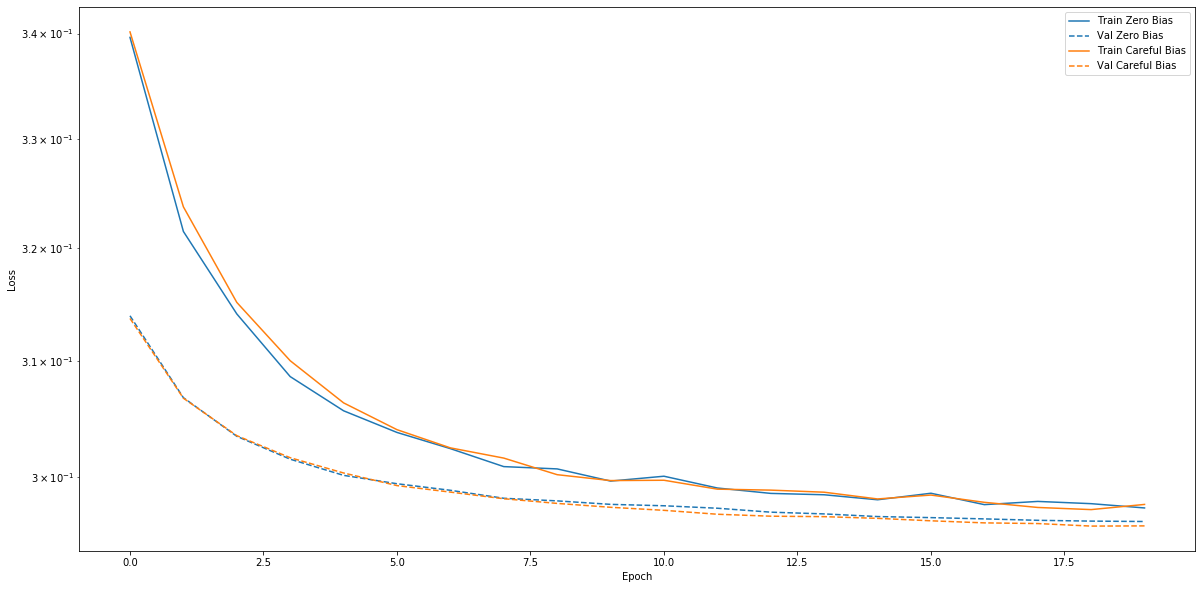

In [101]:
fig,ax = plt.subplots(figsize=(20,10))
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)


In [30]:
print(f1_score(y1,np.round(model.predict(df3[numericFeatures+booleanFeatures]))))
confusion_matrix(y1,np.round(model.predict(df3[numericFeatures+booleanFeatures])))

0.0


array([[72125,     0],
       [ 7260,     0]])

0.3247110598207406

In [16]:
from sklearn.metrics import confusion_matrix,f1_score


In [18]:
import tensorflow_probability as tfp

ModuleNotFoundError: No module named 'tensorflow_probability'

# Reading

https://www.kaggle.com/mlg-ulb/creditcardfraud

Oversample positive class
Undersample negative class